## Convert ARC data to AnnData object and populate the 'obs' info

In [1]:
!date

Wed Aug 30 16:20:16 EDT 2023


#### import libraries

In [2]:
from pandas import read_csv, concat
from scvi.data import read_10x_multiome
from anndata import AnnData
from seaborn import barplot
import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

/home/gibbsr/anaconda3/lib/python3.9/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/gibbsr/anaconda3/lib/python3.9/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (


#### set notebook variables

In [3]:
# naming
project = 'aging_phase2'
modality = 'ARC'
set_name = f'{project}_{modality}'

# directories
wrk_dir = '/labshare/raph/datasets/adrd_neuro/brain_aging/phase2'
info_dir = f'{wrk_dir}/sample_info'
quants_dir = f'{wrk_dir}/quants'

# in files
info_file = f'{info_dir}/{project}.sample_info.csv'
arc_cnt_file = f'{wrk_dir}/src_data/arc/aging_phase2_consensus_aggr/outs/filtered_feature_bc_matrix'
arc_aggr_file = f'{wrk_dir}/src_data/arc/aging_phase2_consensus_aggr/outs/aggr.csv'

# out files
output_file = f'{quants_dir}/{set_name}.raw.h5ad'

# constants
DEBUG = False

#### visualization functions

In [4]:
# function to plot the barcode counts by sample
def plot_sample_barcode_counts(this_df, sample_name, id_col='sample_id'):
    with rc_context({'figure.figsize': (12, 12), 'figure.dpi': 100}):
        plt.style.use('seaborn-talk')    
        barplot(x=this_df[id_col].value_counts().index, 
                y=this_df[id_col].value_counts().values, 
                order=this_df[id_col].value_counts().index,
                palette='Blues_d')
        plt.xticks(rotation=90, fontsize=8)
        plt.tight_layout()
        plt.title(sample_name)
        plt.ylabel('barcode counts')
        plt.show()
    print(this_df[id_col].value_counts())

### load the sample info data

In [5]:
info_df = read_csv(info_file)
print(f'shape of info {info_df.shape}')
info_df = info_df.rename(columns={'hbcc_id': 'donor_id'})
if DEBUG:
    display(info_df.head())
    display(info_df.gex_pool.value_counts())
    display(info_df.atac_pool.value_counts())    

shape of info (36, 13)


### read the 10X ARC data

In [6]:
%%time
# read multiomic data
adata = read_10x_multiome(arc_cnt_file)
adata.var_names_make_unique()
adata.obs_names_make_unique()

CPU times: user 2min 45s, sys: 1.33 s, total: 2min 47s
Wall time: 2min 46s


/home/gibbsr/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/gibbsr/anaconda3/lib/python3.9/site-packages/anndata/_core/anndata.py:1840: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [7]:
print(adata)
if DEBUG:
    display(adata.obs.head())

AnnData object with n_obs × n_vars = 18671 × 258031
    obs: 'batch_id'
    var: 'ID', 'modality', 'chr', 'start', 'end'


#### from the cellranger-arc aggr command the batch_id's should match the index from the aggr library file

In [8]:
aggr_lib = read_csv(arc_aggr_file)
aggr_lib = aggr_lib[['library_id']]
aggr_lib.library_id = aggr_lib.library_id.str.replace('Ag', 'Aging')
aggr_lib['batch_id'] = aggr_lib.index + 1
print(aggr_lib.shape)
if DEBUG:
    display(aggr_lib.head())

(3, 2)


#### merge the lib ID based on obs batch_id

In [9]:
prev_index = adata.obs.index.copy()
adata.obs['sample_id'] = adata.obs.batch_id.map(aggr_lib.set_index('batch_id')['library_id'])

print(adata.obs.shape)
print(prev_index.equals(adata.obs.index))
if DEBUG:
    display(adata.obs.head())

(18671, 2)
True


#### check the modality counts

In [10]:
adata.var.modality.value_counts()

modality
Peaks              221430
Gene Expression     36601
Name: count, dtype: int64

### merge the sample info into the obs

In [11]:
obs_id_df = adata.obs.copy()
print(obs_id_df.shape)
obs_id_df['barcode'] = obs_id_df.index.values
obs_id_df = obs_id_df.merge(info_df, how='left', left_on='sample_id', right_on='sample_id')
obs_id_df = obs_id_df.set_index('barcode')
obs_id_df = obs_id_df.reindex(adata.obs.index)
# add columns for phase1 migrated pools compatibility later
obs_id_df['phase1_cluster'] = 'NA'
obs_id_df['phase1_celltype'] = 'NA'
# fill any missing barcode IDs
obs_id_df['sample_id'] = obs_id_df['sample_id'].fillna('unknown')
# drop the extra unneeded column
obs_id_df = obs_id_df.drop(columns=['batch_id'])
print(obs_id_df.shape)
if DEBUG:
    display(obs_id_df.head())

(18671, 2)
(18671, 15)


#### add the new obs info table into the anndata obs

In [12]:
print(adata.obs.index.equals(obs_id_df.index))
adata.obs = adata.obs.drop(columns=['batch_id', 'sample_id'])
adata.obs = concat([adata.obs, obs_id_df], axis='columns')
print(adata.obs.index.equals(prev_index))
print(adata)

if DEBUG:
    display(adata.obs.head())

True
True
AnnData object with n_obs × n_vars = 18671 × 258031
    obs: 'sample_id', 'donor_id', 'geno_IID', 'sex', 'ancestry', 'age', 'gex_pool', 'atac_pool', 'pmi', 'ph', 'smoker', 'bmi', 'rin', 'phase1_cluster', 'phase1_celltype'
    var: 'ID', 'modality', 'chr', 'start', 'end'


### visualize the counts 

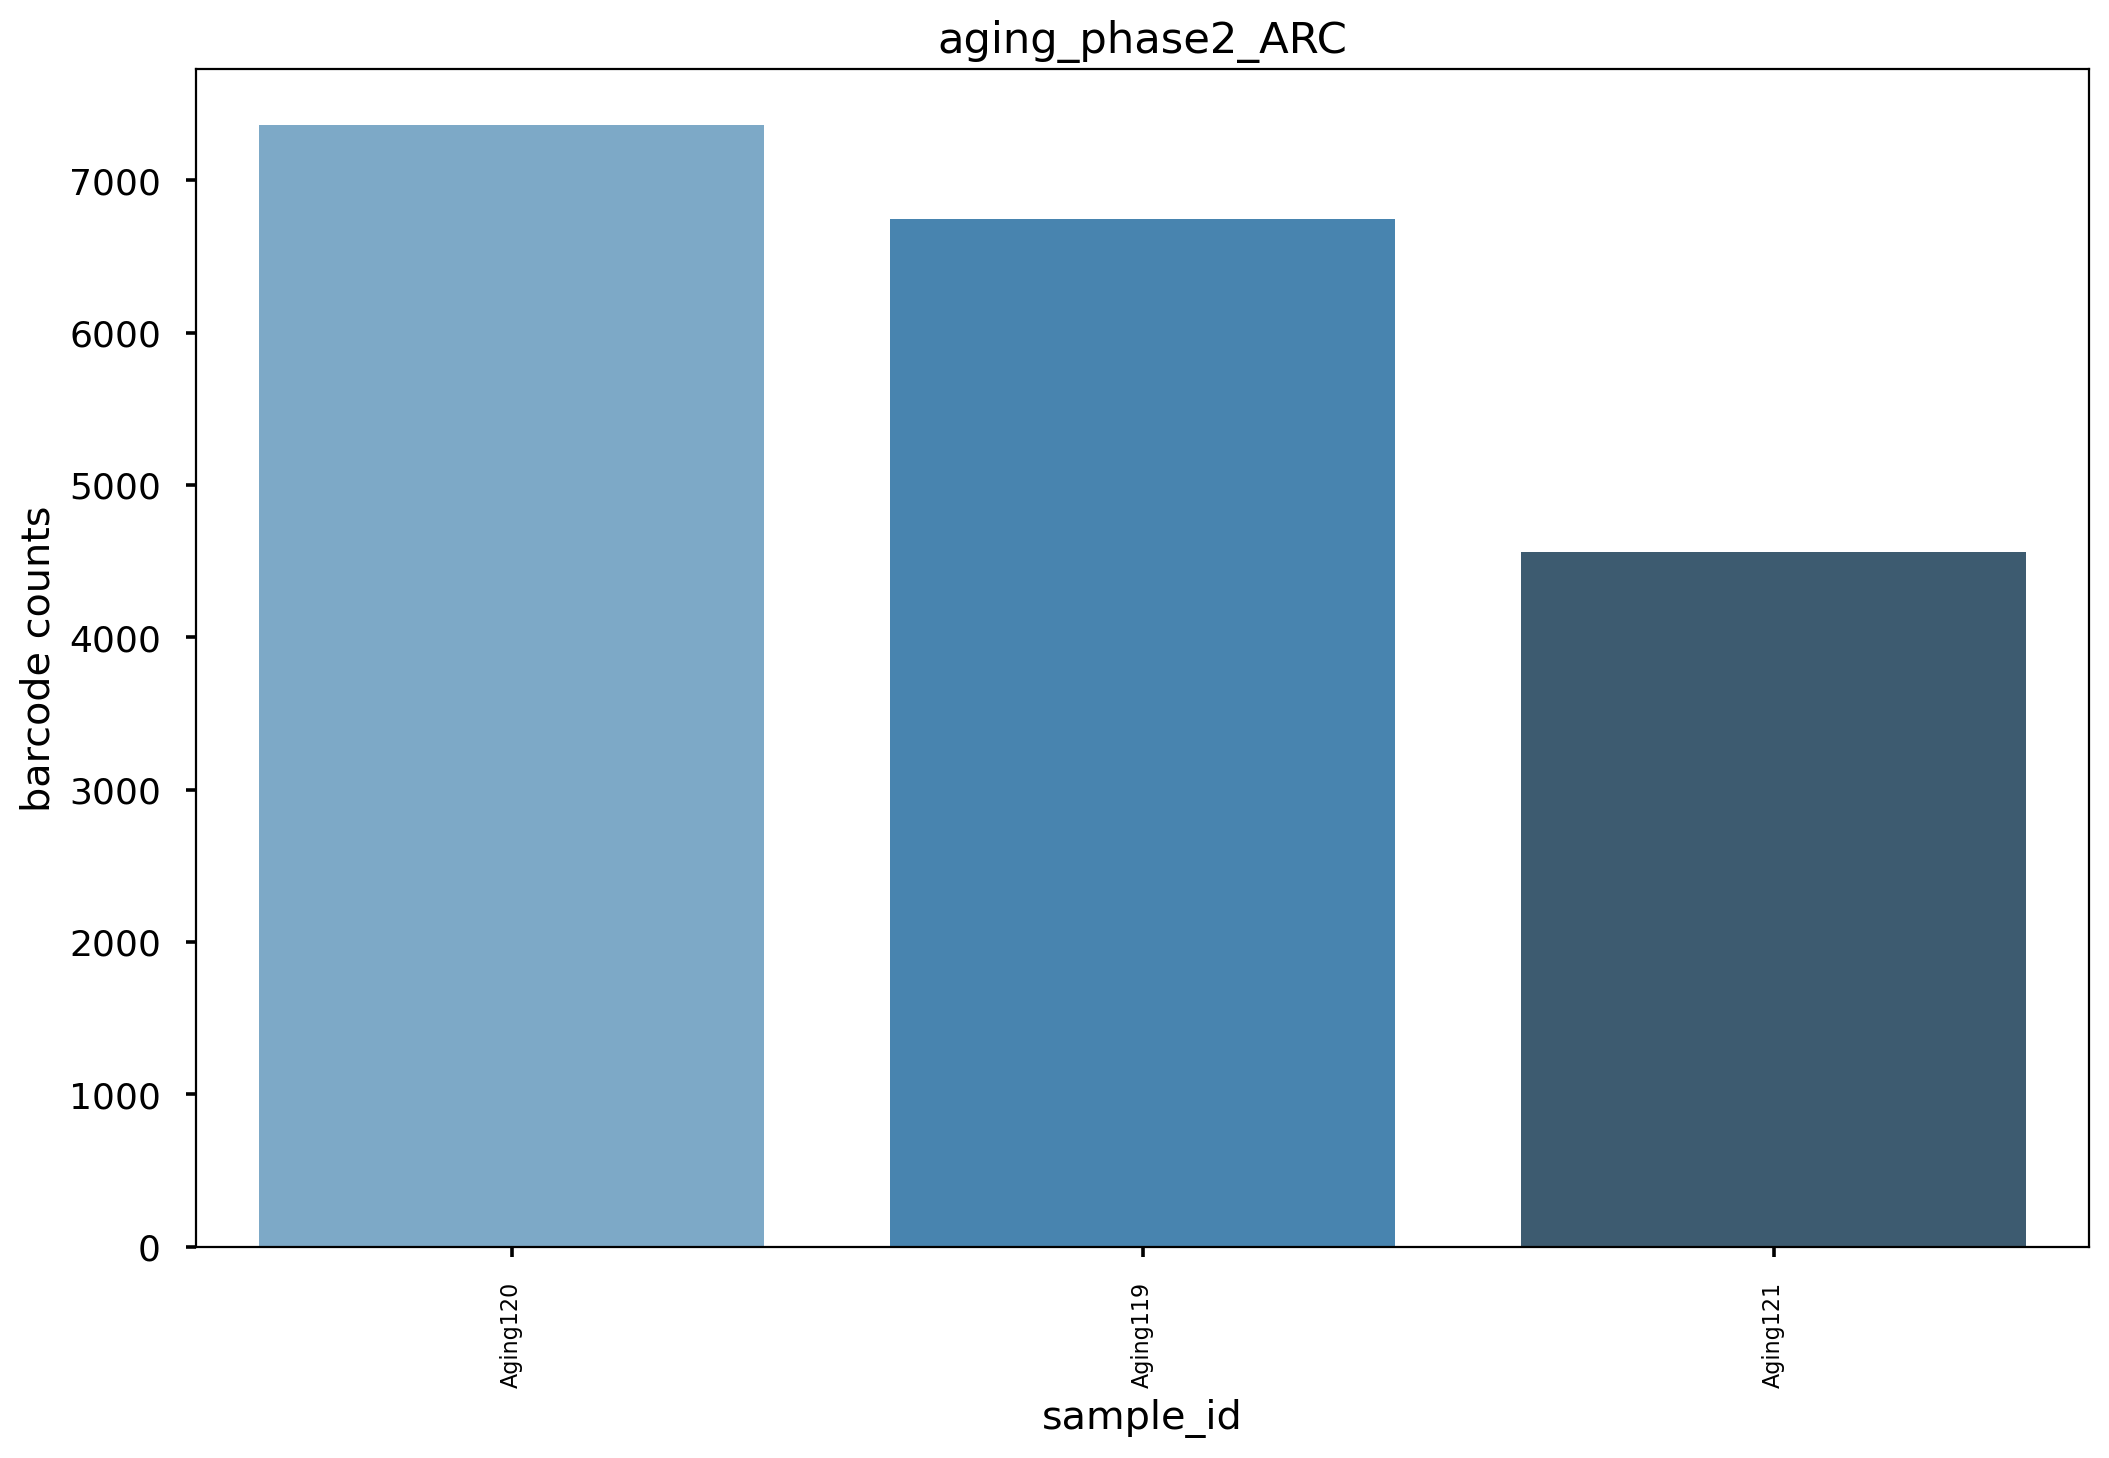

sample_id
Aging120    7360
Aging119    6749
Aging121    4562
Name: count, dtype: int64


In [13]:
plot_sample_barcode_counts(adata.obs, set_name)

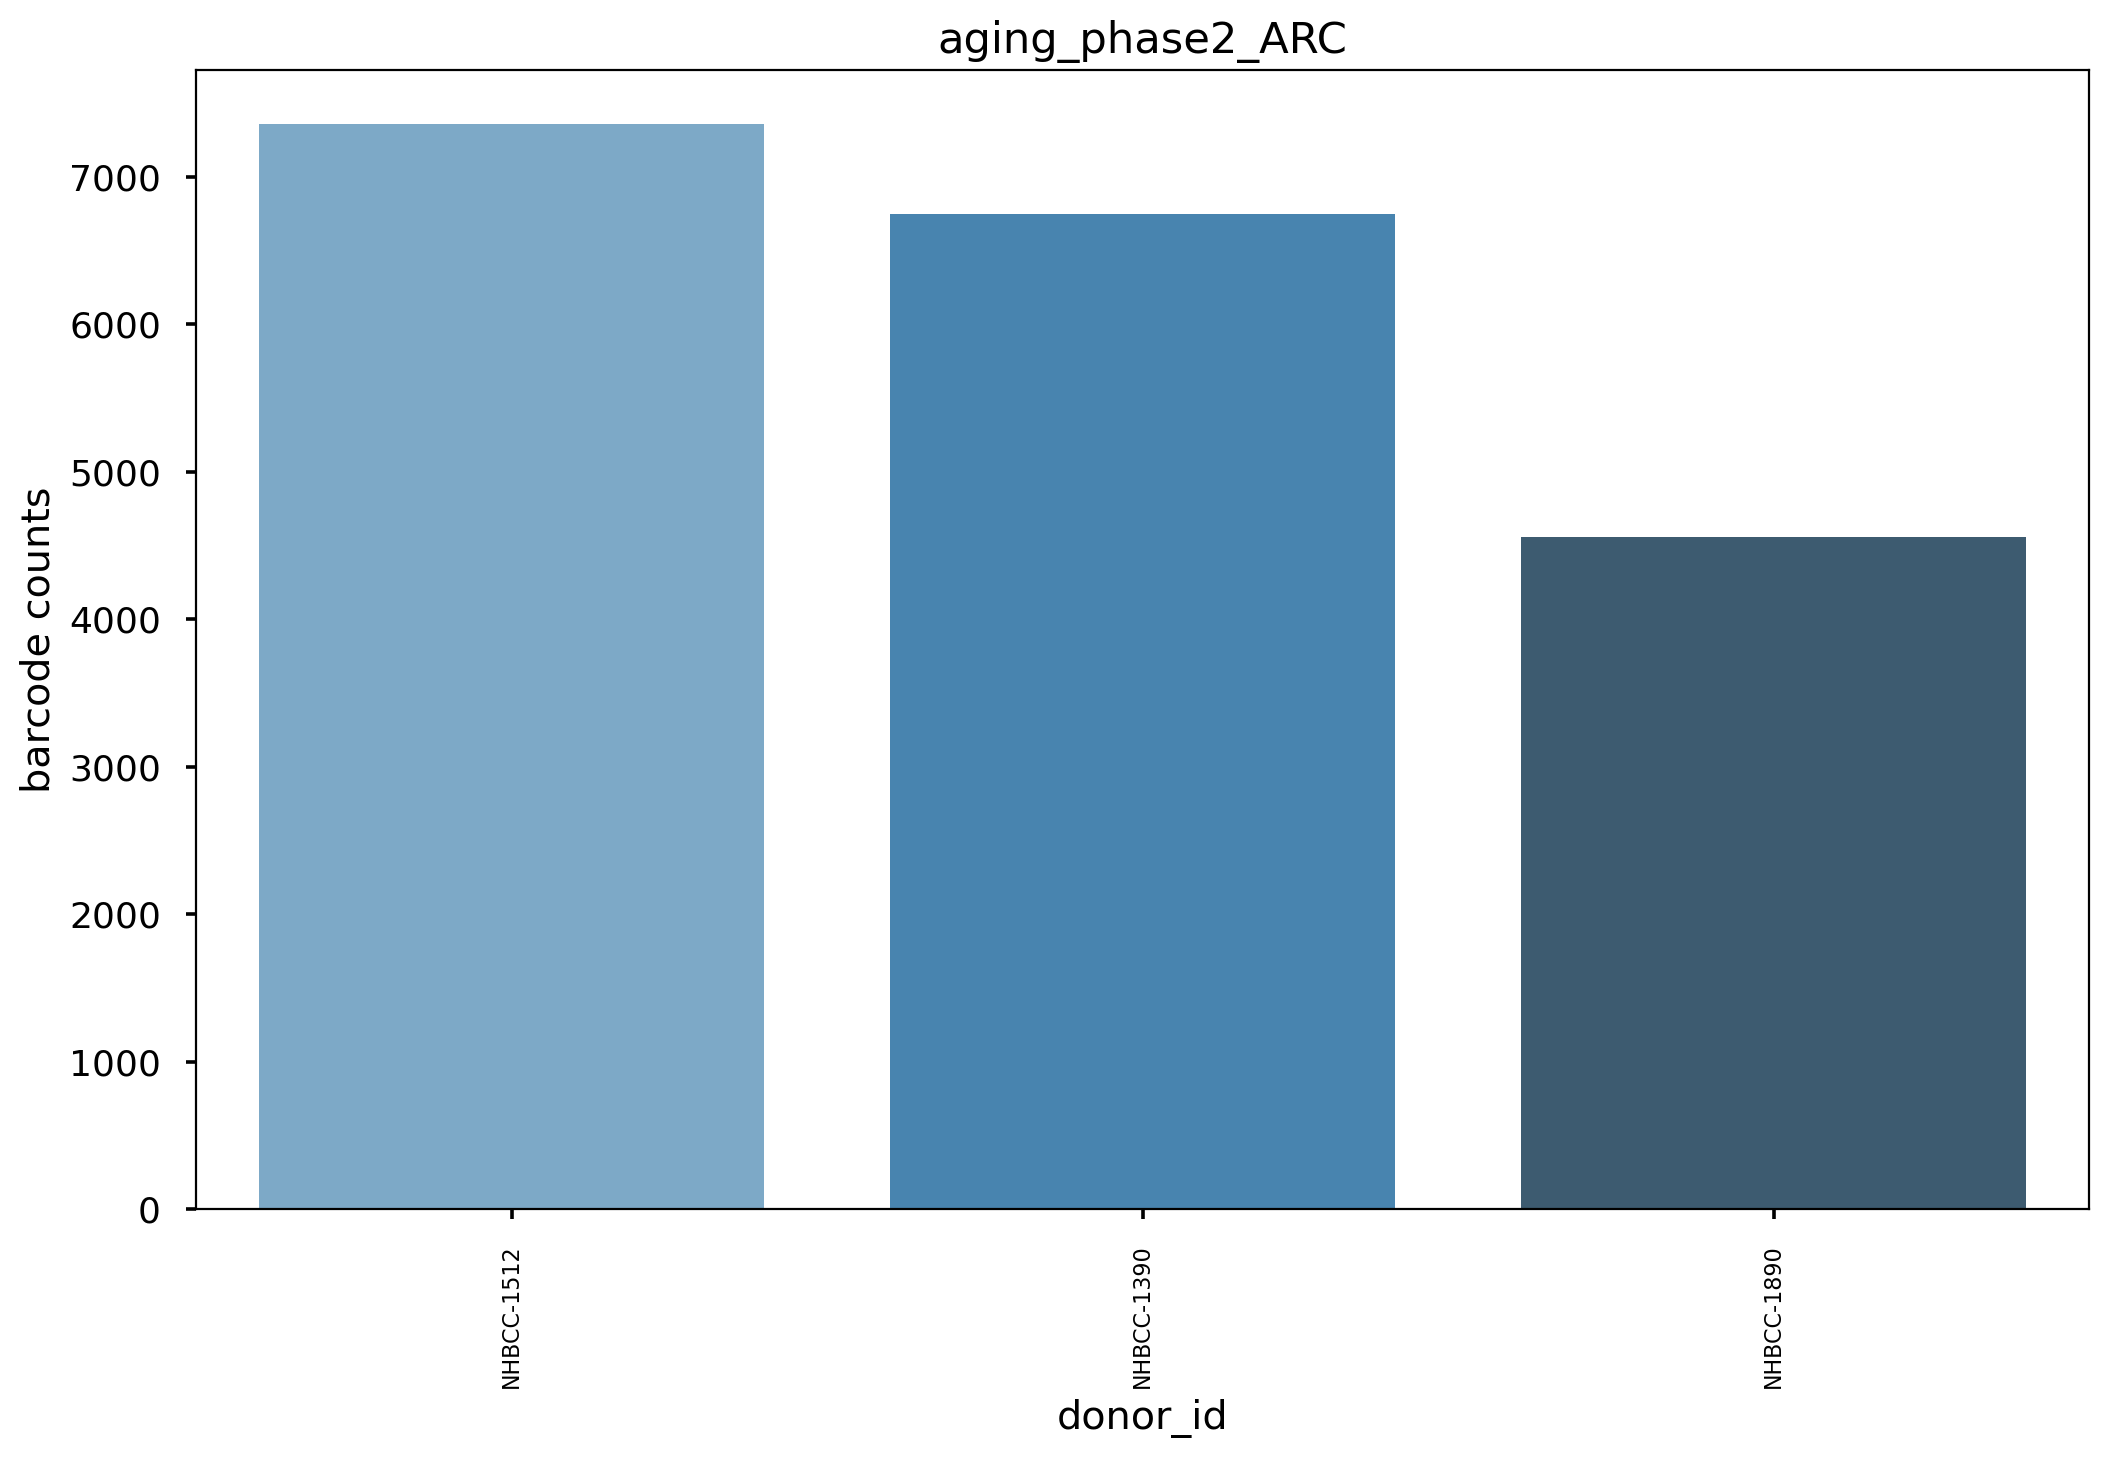

donor_id
NHBCC-1512    7360
NHBCC-1390    6749
NHBCC-1890    4562
Name: count, dtype: int64


In [14]:
plot_sample_barcode_counts(adata.obs, set_name, 'donor_id')

### save output file

In [15]:
%%time
adata.write(output_file)

CPU times: user 797 ms, sys: 729 ms, total: 1.53 s
Wall time: 3.97 s


In [16]:
!date

Wed Aug 30 16:23:12 EDT 2023
